In [1]:
import sys
sys.path.insert(0, '/home/xhding/workspaces/torch-deep-retina')
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
import torch
from kinetic.evaluation import *
from kinetic.utils import select_model
from kinetic.config import get_custom_cfg
from kinetic.data import TestDataset
from torchdeepretina.utils import *

In [3]:
device = torch.device('cuda:0')
model = KineticsChannelModel().to(device)
cfg = get_custom_cfg('channel')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/channel/epoch_080_loss_-3.33_pearson_0.4375.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

KineticsChannelModel(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Flatten()
    (2): BatchNorm1d(10368, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (3): GaussianNoise(std=0.05, trainable=False, adapt=False, momentum=0.95)
    (4): Softplus(beta=1, threshold=20)
    (5): Clamp()
    (6): Multiply()
    (7): Reshape(shape=(-1, 8, 1296))
  )
  (kinetics): Kinetics_channel(dt=0.001)

In [4]:
test_data =  DataLoader(TestDataset(cfg), batch_size=1)
test_pc, pred, targ = pearsonr_eval(model, test_data, 5, device)
test_pc

0.5706678581911098

In [5]:
test_data =  DataLoader(TestDataset(cfg), batch_size=1, shuffle=True)
test_pc, _, _ = pearsonr_eval(model, test_data, 5, device)
test_pc

0.15161894836633308

In [11]:
for key in checkpoint['model_state_dict'].keys():
    if 'kinetics' in key:
        print(key, checkpoint['model_state_dict'][key])

kinetics.ka tensor([[ 1.0000],
        [ 1.0000],
        [ 1.0000],
        [ 1.0000],
        [ 1.0000],
        [-1.0000],
        [ 1.0000],
        [ 1.0000]], device='cuda:1')
kinetics.kfi tensor([[ 0.9982],
        [ 0.9220],
        [ 0.9997],
        [ 0.8444],
        [ 0.9985],
        [ 0.2441],
        [-0.9991],
        [ 0.9999]], device='cuda:1')
kinetics.kfr tensor([[-1.0000],
        [-0.9783],
        [ 0.6897],
        [ 0.6736],
        [ 1.0000],
        [-0.8782],
        [ 1.0000],
        [ 0.9782]], device='cuda:1')
kinetics.ksi tensor([[-8.0042e-05],
        [ 5.8578e-04],
        [ 1.5829e-04],
        [-1.5062e-04],
        [ 2.6461e-03],
        [ 5.4800e-04],
        [ 8.2148e-04],
        [ 1.5230e-04]], device='cuda:1')
kinetics.ksr tensor([[-8.3430e-06],
        [-7.4978e-06],
        [ 5.8411e-06],
        [ 2.1855e-06],
        [-1.8767e-05],
        [-6.5332e-07],
        [-7.8537e-06],
        [ 1.7386e-05]], device='cuda:1')


(0, 1)

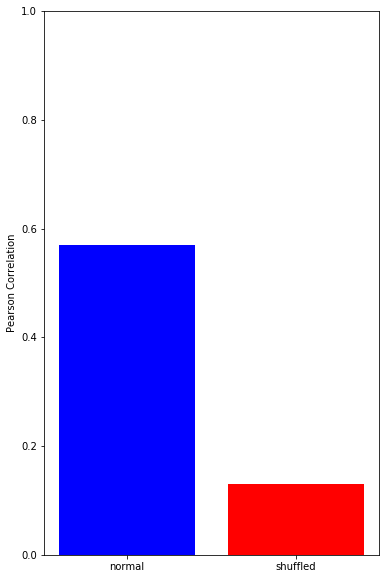

In [24]:
fig, ax = plt.subplots(figsize=(6,10))
rects1 = ax.bar(['normal', 'shuffled'], [0.57, 0.13], color=['blue', 'red'])
ax.set_ylabel('Pearson Correlation')
ax.set_ylim([0, 1])

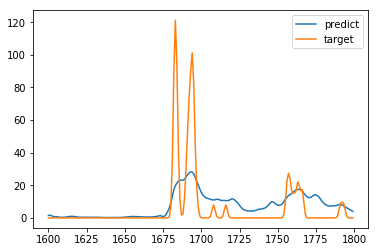

In [11]:
plt.plot(np.arange(1600,1800),pred[1600:1800,3], label='predict')
plt.plot(np.arange(1600,1800),targ[1600:1800,3], label='target')
plt.legend()

In [7]:
targ.shape

(5956, 5)